In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import os
import gc
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from skopt.space import Real, Categorical, Integer
OriginDataDir = '../../Data/OriginData'
TrainTestDataDir = '../../Data/TrainTestData'
ModelSaveDir = 'models'
ResultSaveDir = 'result'

In [5]:
def loadData(DataName):
    DataPath = os.path.join(TrainTestDataDir, DataName)
    if not os.path.exists(DataPath):
        print('%s does not exist!' % DataPath)
        return
    OriginData = pd.read_csv(DataPath, index_col=0)
    #OriginData = OriginData.sample(frac=1)  # 打乱顺序后返回
    return OriginData

In [6]:
def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [7]:
TrainPath = os.path.join(OriginDataDir,'application_train.csv')
df_train_ori = pd.read_csv(TrainPath)
TestPath = os.path.join(OriginDataDir,'application_test.csv')
df_test_ori = pd.read_csv(TestPath)
df_all = df_train_ori.append(df_test_ori)
df_all.reset_index(drop=True,inplace=True)
df_all.head()

/home/guest/anaconda2/envs/py3/lib/python3.5/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,TARGET,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0149,"Stone, brick",WEDNESDAY,0.9722,0.9722,0.9722,0.6192,0.6243,0.6341
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0714,Block,MONDAY,0.9851,0.9851,0.9851,0.7960,0.7987,0.8040
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,MONDAY,NaN,NaN,NaN,NaN,NaN,NaN
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,WEDNESDAY,NaN,NaN,NaN,NaN,NaN,NaN
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,THURSDAY,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
categoryFeats = ['SK_ID_CURR','ORGANIZATION_TYPE']

In [8]:
df_need = df_all[categoryFeats]
df_need = LabelEncoder().fit_transform(df_need.ORGANIZATION_TYPE)
df_need.head()

/home/guest/anaconda2/envs/py3/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,SK_ID_CURR,ORGANIZATION_TYPE
0,100002,5
1,100003,39
2,100004,11
3,100006,5
4,100007,37


In [14]:
df_need.ORGANIZATION_TYPE = df_need.ORGANIZATION_TYPE.astype('category')

/home/guest/anaconda2/envs/py3/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [17]:
df_need.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Data columns (total 2 columns):
SK_ID_CURR           356255 non-null int64
ORGANIZATION_TYPE    356255 non-null category
dtypes: category(1), int64(1)
memory usage: 3.1 MB


In [2]:
TestData = loadData('test.csv')
TestData.drop(TestData.filter(regex='ORGANIZATION_TYPE*').columns.tolist(),axis=1,inplace=True)
TestData = pd.merge(TestData,df_need,on='SK_ID_CURR',how='left')
TestID = TestData.SK_ID_CURR.values
TestData.drop('SK_ID_CURR', axis=1, inplace=True)
TrainData = loadData('train.csv')
TrainData.reset_index(drop=True, inplace=True)
TrainData.drop(TrainData.filter(regex='ORGANIZATION_TYPE*').columns.tolist(),axis=1,inplace=True)
TrainData = pd.merge(TrainData,df_need,on='SK_ID_CURR',how='left')
TrainData.drop('SK_ID_CURR', axis=1, inplace=True)
ValData = loadData('validation.csv')
ValData.reset_index(drop=True, inplace=True)
ValData.drop(ValData.filter(regex='ORGANIZATION_TYPE*').columns.tolist(),axis=1,inplace=True)
ValData = pd.merge(ValData,df_need,on='SK_ID_CURR',how='left')
ValData.drop('SK_ID_CURR', axis=1, inplace=True)
AllTrainData = TrainData.append(ValData)
AllTrainData.reset_index(drop=True, inplace=True)

NameError: name 'loadData' is not defined

In [1]:
AllTrainData.ORGANIZATION_TYPE.head()

NameError: name 'AllTrainData' is not defined

In [20]:
AllTrainData.shape

(307511, 637)

In [21]:
TrainData.ORGANIZATION_TYPE.head()

0    33
1    57
2    42
3    41
4     5
Name: ORGANIZATION_TYPE, dtype: category
Categories (58, int64): [0, 1, 2, 3, ..., 54, 55, 56, 57]

In [10]:
TestData.shape

(48744, 636)

In [1]:
def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [26]:
features = [x for x in TrainData.columns if x != 'TARGET' and x != 'SK_ID_CURR']

In [27]:
len(features)

636

In [11]:
bayes_cv_tuner = BayesSearchCV(
    estimator = lgb.LGBMClassifier(
        application='binary',
        metric='auc',
        n_jobs=-1,
        verbose=0
    ),
    search_spaces = {
        'boosting' = Categorical(['dart', 'gbdt'])
        'learning_rate': (0.01, 0.3, 'uniform'),
        "drop_rate":(0.01, 0.2, 'uniform'),
        'num_leaves': (1, 225),      
        'max_depth': (0, 8),
        'feature_fraction':(0.5, 1.0, 'uniform'),
        "min_data_in_leaf":(20, 100),
        'min_child_samples': (0, 50),
        'min_split_gain':(0, 1, 'uniform'),
        'colsample_bytree'= (0.5, 1, 'uniform'),
        'subsample'= (0.5, 1, 'uniform'),
        'max_bin': (100, 255),
        'reg_lambda': (1e-9, 1.0, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'scale_pos_weight': (1,12, 'uniform'),
},    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=42
    ),
    n_jobs = -1, 
    verbose = 0,
    refit = True,
    random_state = 921
)

# Fit the model
result = bayes_cv_tuner.fit(AllTrainData[features], AllTrainData['TARGET'], callback=status_print)

In [1]:
model = LGBMClassifier(
            nthread=-1,
            boosting = "dart"
            #is_unbalance=True,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=31,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.04,
            reg_lambda=0.073,
            min_split_gain=0.0222415,
            min_child_weight=40,
            drop_rate = 0.03,
            silent=-1,
            verbose=-1,
            #scale_pos_weight=11
            )

SyntaxError: invalid syntax (<ipython-input-1-dc29744dd7e1>, line 5)

In [23]:
lgbm_params = {
    "boosting":"dart",
    "application":"binary",
    "learning_rate": 0.1,
    'reg_alpha':0.041545473,
    'reg_lambda': 0.0735294,
    "n_estimators":10000,
    "max_depth":8,
    "num_leaves":34,
    "max_bin":225,
    "drop_rate":0.03,
    "colsample_bytree":0.9497036,
    "subsample":0.8715623,
    "min_split_gain":0.0222415,
    "min_child_weight":39.3259775
}

In [2]:
model = lgb.LGBMClassifier(application="binary", boosting_type=lgbm_params["boosting"],
                          learning_rate=lgbm_params["learning_rate"],n_estimators=lgbm_params["n_estimators"],drop_rate=lgbm_params["drop_rate"],
                          num_leaves=lgbm_params["num_leaves"], max_depth=lgbm_params["max_depth"],
                          max_bin=lgbm_params["max_bin"], num_threads =-1,colsample_bytree=lgbm_params["colsample_bytree"],
                          subsample=lgbm_params["subsample"],min_split_gain=lgbm_params["min_split_gain"],
                          min_child_weight=lgbm_params["min_child_weight"])
#                           min_data_in_leaf=lgbm_params["min_data_in_leaf"],
#                            feature_fraction=lgbm_params["feature_fraction"],

NameError: name 'lgb' is not defined

In [32]:
feature_importances = np.zeros(len(features))
for i in range(2):
    train_data, test_data, train_y, test_y = train_test_split(AllTrainData[features],AllTrainData['TARGET']
                                                              ,test_size=0.2)
    model.fit(train_data, train_y, early_stopping_rounds=200, 
              eval_set=[(test_data, test_y)],eval_metric='auc', verbose=200)
    feature_importances += model.feature_importances_  

Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.771039
[400]	valid_0's auc: 0.782103
[600]	valid_0's auc: 0.785751
[800]	valid_0's auc: 0.787283
[1000]	valid_0's auc: 0.788074
[1200]	valid_0's auc: 0.788252
[1400]	valid_0's auc: 0.788345
Early stopping, best iteration is:
[1365]	valid_0's auc: 0.788438
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.774907
[400]	valid_0's auc: 0.784411
[600]	valid_0's auc: 0.78754
[800]	valid_0's auc: 0.788683
[1000]	valid_0's auc: 0.789416
[1200]	valid_0's auc: 0.789848
Early stopping, best iteration is:
[1171]	valid_0's auc: 0.789896


In [33]:
feature_importances = feature_importances/2
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head(30)

,feature,importance
635,ORGANIZATION_TYPE,5379.0
620,CREDIT_TERM,955.5
71,EXT_SOURCE_MIN,582.0
70,EXT_SOURCE_MAX,564.0
7,AMT_ANNUITY,475.0
10,DAYS_BIRTH,458.5
177,DAYS_CREDIT_max,422.5
625,OWN_CAR_perDay,408.0
33,EXT_SOURCE_3,407.5
32,EXT_SOURCE_2,398.0


In [34]:
feature_importances[feature_importances.feature=='ORGANIZATION_TYPE']

,feature,importance
635,ORGANIZATION_TYPE,5379.0


In [35]:
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail(32)

There are 107 features with 0.0 importance


,feature,importance
55,FLAG_DOCUMENT_16,0.0
54,FLAG_DOCUMENT_15,0.0
538,NAME_CLIENT_TYPE_XNA_mean,0.0
52,FLAG_DOCUMENT_13,0.0
438,NAME_CLIENT_TYPE_XNA_max,0.0
51,FLAG_DOCUMENT_12,0.0
544,NAME_CONTRACT_STATUS_Sent proposal_mean_mean,0.0
546,NAME_CONTRACT_STATUS_Demand_mean_mean,0.0
547,NAME_CONTRACT_STATUS_Approved_mean_mean,0.0
548,NAME_CONTRACT_STATUS_Refused_mean_mean,0.0


In [36]:
def plot_feature_importances(df, threshold=0.98):
    
    plt.rcParams["font.size"] = 20
    
    df = df.sort_values('importance', ascending=False).reset_index()
    
    df['importance_normalized'] = df['importance']/df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.figure(figsize=(10,10))
    ax = plt.subplot()
    
    ax.barh(list(reversed(list(df.index[:30]))),
            df['importance_normalized'].head(30),
            align='center', edgecolor='k')
    ax.set_yticks(list(reversed(list(df.index[:30]))))
    ax.set_yticklabels(df['feature'].head(30))
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    plt.figure(figsize=(8,6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of features');plt.ylabel('Cumulative Importances');
    
    plt.title("Cumulative Feature Importance");
    plt.show()
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

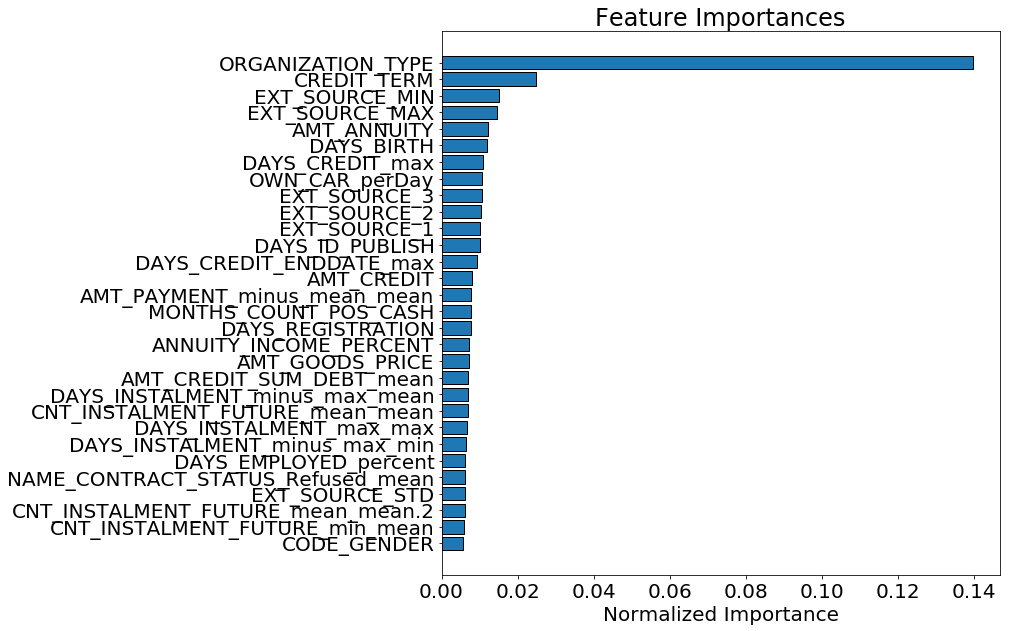

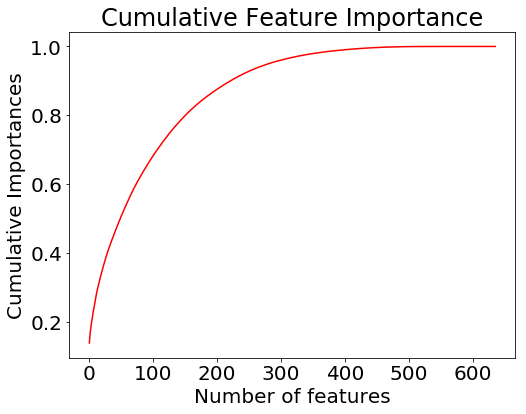

353 features required for 0.98 of cumulative importance


In [37]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [38]:
threshold = 0.98

features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

data = AllTrainData[features_to_keep]
test  = TestData[features_to_keep]

In [39]:
print('Training shape: ', data.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 352)
Testing shape:  (48744, 352)


In [41]:
n_folds = 5
k_fold = KFold(n_splits=n_folds, shuffle=False)

feature_importances_values = np.zeros(data.shape[1])

test_predictions = np.zeros(test.shape[0])
out_of_fold = np.zeros(data.shape[0])

valid_scores = []
train_scores = []

model = LGBMClassifier(
            nthread=-1,
            #is_unbalance=True,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=32,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.04,
            reg_lambda=0.073,
            min_split_gain=0.0222415,
            min_child_weight=40,
            silent=-1,
            verbose=-1,
            #scale_pos_weight=11
            )
for train_indices, test_indices in k_fold.split(data):
    
    train_data, train_y = AllTrainData[features_to_keep].iloc[train_indices], AllTrainData.TARGET.iloc[train_indices]
    test_data, test_y = AllTrainData[features_to_keep].iloc[test_indices], AllTrainData.TARGET.iloc[test_indices]
    
    model.fit(train_data, train_y, eval_metric='auc', eval_set=[(test_data, test_y), (train_data, train_y)],
              eval_names=['valid', 'train'], early_stopping_rounds=200, verbose=200)
    
    best_iteration = model.best_iteration_
    feature_importances_values += model.feature_importances_ / k_fold.n_splits
    
    test_predictions += model.predict_proba(test, num_iteration=best_iteration)[:,1]/k_fold.n_splits
    
    out_of_fold[test_indices] = model.predict_proba(test_data, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
    valid_score = model.best_score_['valid']['auc']
    train_score = model.best_score_['train']['auc']
        
    valid_scores.append(valid_score)
    train_scores.append(train_score)
        
    gc.enable()
    del model, train_data, test_data
    gc.collect()

Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.796243	valid's auc: 0.774647
[400]	train's auc: 0.821719	valid's auc: 0.7855
[600]	train's auc: 0.83839	valid's auc: 0.789003
[800]	train's auc: 0.85182	valid's auc: 0.790666
[1000]	train's auc: 0.863499	valid's auc: 0.791424
[1200]	train's auc: 0.873837	valid's auc: 0.791868
[1400]	train's auc: 0.883321	valid's auc: 0.792055
[1600]	train's auc: 0.891741	valid's auc: 0.792089
Early stopping, best iteration is:
[1511]	train's auc: 0.888167	valid's auc: 0.792207
Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.796007	valid's auc: 0.774578
[400]	train's auc: 0.821483	valid's auc: 0.784328
[600]	train's auc: 0.838251	valid's auc: 0.78764
[800]	train's auc: 0.85198	valid's auc: 0.78902
[1000]	train's auc: 0.863402	valid's auc: 0.78966
[1200]	train's auc: 0.873696	valid's auc: 0.789695
Early stopping, best iteration is:
[1089]	train's auc: 0.868027	valid's auc: 0.789755
Trai

In [42]:
submission = pd.DataFrame({'SK_ID_CURR': TestID, 'TARGET': test_predictions})
submission.to_csv(os.path.join(ResultSaveDir,"submissions02.csv"), index=False)

In [43]:
#保存模型
from sklearn.externals import joblib
joblib.dump(model,os.path.join(ModelSaveDir,"lgb_0792.model"))

NameError: name 'model' is not defined